In [1]:
import os
import cv2
import numpy as np
import imutils
import tensorflow as tf
import matplotlib.pyplot as plt

from imutils import contours
from PIL import Image

In [2]:
!pip install --upgrade imutils

Requirement already up-to-date: imutils in /usr/local/lib/python3.6/dist-packages (0.5.3)


In [3]:
HOME_DIR              = '/tf/'
ROOT_DIR              = '/tf/ocr_credit_card/'
DATASET_DIR           = ROOT_DIR    + 'dataset/'

IMAGE_DIR             = DATASET_DIR + 'credit-card-number/'
LABEL_PATH            = IMAGE_DIR   + 'CardOcrLabel.csv'
TRAIN_ANNOTATION_PATH = IMAGE_DIR   + 'CardOcrLabelTrain.txt'
VAL_ANNOTATION_PATH   = IMAGE_DIR   + 'CardOcrLabelVal.txt'
TABLE_PATH            = IMAGE_DIR   + 'table.txt'

ARTIFACT_PATH         = ROOT_DIR    + 'artifact/' 

In [4]:
def read_img_paths_and_labels(annotation_path):
    img_paths = []
    labels = []

    annotation_folder = os.path.dirname(annotation_path)
    with open(annotation_path) as f:
        content = np.array(
            [line.strip().split() for line in f.readlines()])

    part_img_paths = content[:, 0]    
    part_labels = content[:, 1]
    part_img_paths = [os.path.join(annotation_folder, line)
                      for line in part_img_paths]
    img_paths.extend(part_img_paths)
    labels.extend(part_labels)

    return img_paths, labels


In [135]:
!pip install scikit-image

     |████████████████████████████████| 26.5 MB 86.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 79.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 83.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 80.5 MB/s eta 0:00:01


## Image Gradient Based Edge Detection

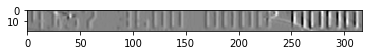

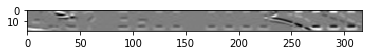

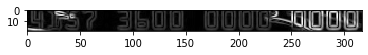

In [5]:
# from skimage.exposure import rescale_intensity

imgPaths, labels = read_img_paths_and_labels(TRAIN_ANNOTATION_PATH)

img = np.array(Image.open(imgPaths[0]))

grayImg = np.round(0.299 * img[:, :, 0] +
                    0.587 * img[:, :, 1] +
                    0.114 * img[:, :, 2]).astype(np.uint8)

imgH, imgW = grayImg.shape

# Prewitt's operator
xKernelP = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
yKernelP = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

# Sobel operator
xKernelS = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
yKernelS = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# know the order of sobel opeartor

sobelX = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="int")
# construct the Sobel y-axis kernel
sobelY = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="int")


def rescalePx(image, in_range='image'):
    if in_range == 'image':
        imin = np.min(image)
        imax = np.max(image)
    else:
        imin, imax = in_range
    image = np.clip(image, imin, imax)
    if imin != imax:
        image = (image - imin) / float(imax - imin)
    return image


def convolve(image, kernel):
    imgH, imgW = image.shape
    kernelH, kernelW = kernel.shape
    pad = (kernelW - 1) // 2
    
    image = cv2.copyMakeBorder(
        image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
    output = np.zeros((imgH, imgW), dtype='float32')
    
    for y in np.arange(pad, imgH + pad):
        for x in np.arange(pad , imgW + pad):
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
            dt = (roi * kernel).sum()
            output[y - pad, x - pad] = dt
    
#     output = rescalePx(output, in_range=(0, 255)) # rescale pixel intensity
#     output = (output * 255).astype("uint8")
    
    return output


dxImg = convolve(grayImg, xKernelS)
dyImg = convolve(grayImg, yKernelS)
dfImg = np.sqrt(pow(dxImg, 2.0) + pow(dyImg, 2.0))

plt.figure()
plt.imshow(dxImg, cmap='gray')
plt.show()

plt.figure()
plt.imshow(dyImg, cmap='gray')
plt.show()

plt.figure()
plt.imshow(dfImg, cmap='gray')
plt.show()


## Image Thresholding (Segmentation)

132


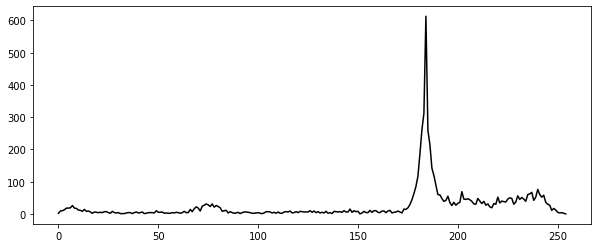

In [6]:
import math


def automaticThresholding(histogram, limit):
    N = np.sum(histogram)
    q = np.expand_dims(np.arange(0, 255, 1), axis=1)
    thres_out = 0
    thres_in = math.floor(np.sum(histogram * q) / N)

    while abs(thres_in - thres_out) > limit:
        thres_out = thres_in
        Nob = np.sum(histogram[:thres_out])
        Nbg = np.sum(histogram[thres_out+1:])
        qOb = np.expand_dims(np.arange(0, thres_out, 1), axis=1)
        qBg = np.expand_dims(np.arange(thres_out+1, 255, 1), axis=1)
        muOb = np.sum(histogram[:thres_out] * qOb) / Nob
        muBg = np.sum(histogram[thres_out+1:] * qBg) / Nbg
        thres_in = math.floor((muOb + muBg) / 2)
        
    return thres_in

limit = 30
histogram = cv2.calcHist([grayImg], [0], None, [255], [0, 255])
thres = automaticThresholding(histogram, limit)
print(thres)

plt.figure(figsize=(10, 4))
plt.plot(histogram, color='k')
plt.show()

grayImg = cv2.adaptiveThreshold(
    grayImg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 17, 0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


132


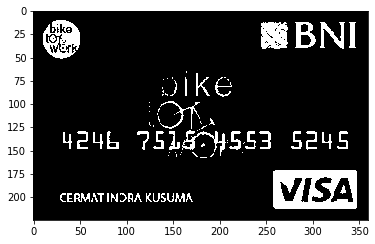

In [7]:
samplePath = DATASET_DIR + 'credit-card/' + 'cxjz9cm79fvf1fdtanpn.jpg'
image = cv2.imread(samplePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def otsuThreshold(img, minVal, maxVal):
    blur = cv2.GaussianBlur(img,(5,5),0)
    
    hist = cv2.calcHist([blur],[0], None, [maxVal+1], [minVal, maxVal+1])
    bins = np.arange(maxVal+1)

    hist_norm = hist.ravel() / hist.max()
    Q = hist_norm.cumsum()

    vMin = np.inf
    thresh = -1

    for i in range(maxVal+1):
        p1, p2 = np.hsplit(hist_norm, [i]) # weigths
        q1, q2 = Q[i], Q[maxVal]-Q[i] # Sum of weights on foreground and background
        b1, b2 = np.hsplit(bins, [i]) # pixel values

        m1, m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1, v2 = np.sum(((b1-m1)**2)*p1)/q1, np.sum(((b2-m2)**2)*p2)/q2
        vWithin = v1*q1 + v2*q2
        # vBetween = p1*p2 * ((m1 - m2)**2)
        
        if vWithin < vMin:
            vMin = vWithin
            thresh = i
            
    return thres


thres = otsuThreshold(gray, 0, 255)
print(thres)


binary = gray > thres
plt.figure()
plt.imshow(binary, cmap='gray')
plt.show()


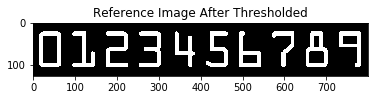

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


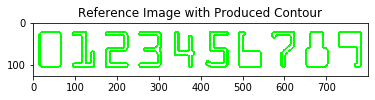

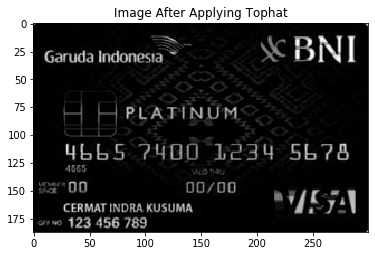

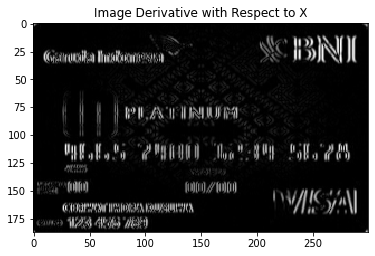

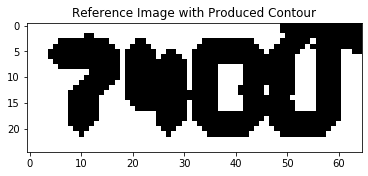

0.625
(16, 10)
[[  0   0   0   0   0 255 255   0   0   0]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [  0   0   0   0   0   0   0   0 255 255]
 [  0   0   0   0   0   0   0   0 255 255]
 [  0   0   0   0   0   0   0   0 255 255]
 [  0   0   0   0   0   0   0 255 255 255]
 [  0   0   0   0   0   0 255 255 255   0]
 [  0   0   0   0   0 255 255 255   0   0]
 [  0   0   0   0 255 255 255   0   0   0]
 [  0   0   0   0 255 255   0   0   0   0]
 [  0   0   0   0 255 255   0   0   0   0]
 [  0   0   0   0 255 255   0   0   0   0]
 [  0   0   0   0 255 255   0   0   0   0]
 [  0   0   0   0 255 255   0   0   0   0]
 [  0   0   0   0 255   0   0   0   0   0]]


0.6
(15, 9)
[[255 255   0   0   0   0   0   0   0]
 [255 255   0   0   0   0   0   0   0]
 [255 255   0   0   0   0 255 255   0]
 [255 255   0   0   0   0 255 255   0]
 [255 255   0   0   0   0 255 255   0]
 [255 255   0   0   0   0 255 255   0]
 [255 255   0   0   0   0 255 255   0]
 [255 255   0   0   0 255 255 255   0]
 [255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255]
 [  0   0   0   0   0   0 255 255   0]
 [  0   0   0   0   0   0 255 255   0]
 [  0   0   0   0   0   0 255 255   0]
 [  0   0   0   0   0   0 255 255   0]
 [  0   0   0   0   0   0 255   0   0]]


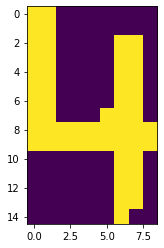

0.7333333333333333
(15, 11)
[[255 255 255 255 255 255 255 255 255 255   0]
 [255 255 255 255 255 255 255 255 255 255 255]
 [255 255   0   0   0   0   0   0 255 255 255]
 [255 255   0   0   0   0   0   0 255 255 255]
 [255 255   0   0   0   0   0   0 255 255 255]
 [255 255   0   0   0   0   0   0 255 255 255]
 [255 255   0   0   0   0   0   0 255 255 255]
 [255 255   0   0   0   0   0   0 255 255   0]
 [255 255   0   0   0   0   0   0 255 255   0]
 [255 255   0   0   0   0   0   0 255 255 255]
 [255 255   0   0   0   0   0   0 255 255 255]
 [255 255   0   0   0   0   0   0 255 255 255]
 [255 255 255   0   0   0   0   0 255 255 255]
 [255 255 255 255 255 255 255 255 255 255   0]
 [  0 255 255 255 255 255 255 255 255   0   0]]


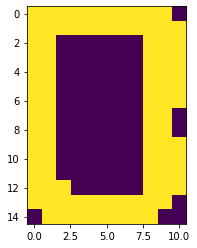

0.85
(20, 17)
[[  0   0   0 255 255 255 255 255 255 255 255   0   0   0   0   0   0]
 [  0   0   0 255 255 255 255 255 255 255 255 255   0   0   0   0 255]
 [  0   0   0   0 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [  0   0   0   0 255 255 255 255 255 255 255 255   0   0   0 255 255]
 [  0   0   0 255 255 255 255 255 255 255   0   0   0   0   0   0   0]
 [  0 255 255 255 255 255 255 255 255 255 255   0   0   0   0   0   0]
 [  0 255 255 255 255 255 255 255 255 255 255   0   0   0   0   0   0]
 [  0 255 255   0   0   0   0   0   0 255 255   0   0   0   0   0   0]
 [  0 255 255   0   0   0   0   0   0 255 255   0   0   0   0   0   0]
 [  0 255 255   0   0   0   0   0   0 255 255   0   0   0   0   0   0]
 [  0 255 255   0   0   0   0   0   0 255 255   0   0   0   0   0   0]
 [  0 255 255   0   0   0   0   0   0 255 255   0   0   0   0   0   0]
 [  0 255 255   0   0   0   0   0   0 255 255   0   0   0   0   0   0]
 [  0 255 255   0   0   0   0   0   0 255 255   0   0   0   0  

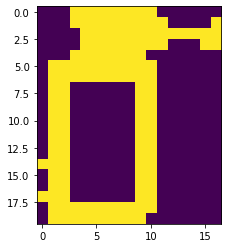

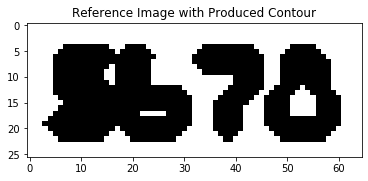

0.7333333333333333
(15, 11)
[[  0   0 255 255 255 255 255 255 255 255 255]
 [  0   0 255 255 255 255 255 255 255 255   0]
 [  0   0 255 255 255   0   0   0   0   0   0]
 [  0   0 255 255 255   0   0   0   0   0   0]
 [  0   0 255 255 255   0   0   0   0   0   0]
 [  0   0 255 255 255   0   0   0   0   0   0]
 [  0   0 255 255 255 255 255 255 255 255   0]
 [  0   0 255 255 255 255 255 255 255 255 255]
 [  0   0   0 255 255 255 255 255 255 255 255]
 [  0   0   0   0   0   0   0   0 255 255 255]
 [  0   0   0   0   0   0   0   0 255 255 255]
 [  0   0   0   0   0   0   0   0 255 255 255]
 [  0 255 255   0   0   0   0   0 255 255 255]
 [255 255 255 255 255 255 255 255 255 255   0]
 [  0 255 255 255 255 255 255 255 255 255   0]]


0.7333333333333333
(15, 11)
[[255 255 255 255   0   0   0   0   0   0   0]
 [255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255   0   0   0   0   0 255 255 255]
 [255 255 255   0   0   0   0   0 255 255 255]
 [255 255 255   0   0   0   0   0 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255]
 [  0 255 255 255 255 255 255 255 255 255   0]]


0.6666666666666666
(15, 10)
[[255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [  0   0   0   0   0   0   0   0 255 255]
 [  0   0   0   0   0   0   0   0 255 255]
 [  0   0   0   0   0   0   0   0 255 255]
 [  0   0   0   0   0   0   0   0 255 255]
 [  0   0   0   0   0   0   0 255 255 255]
 [  0   0   0   0   0   0 255 255 255   0]
 [  0   0   0   0   0 255 255   0   0   0]
 [  0   0   0   0 255 255 255   0   0   0]
 [  0   0   0   0 255 255   0   0   0   0]
 [  0   0   0   0 255 255   0   0   0   0]
 [  0   0   0   0 255 255   0   0   0   0]
 [  0   0   0   0 255 255   0   0   0   0]
 [  0   0   0   0 255 255   0   0   0   0]]


0.7333333333333333
(15, 11)
[[  0   0   0 255 255 255 255 255   0   0   0]
 [  0   0   0 255 255 255 255 255 255   0   0]
 [  0   0   0 255 255   0 255 255 255   0   0]
 [  0   0   0 255 255   0 255 255 255   0   0]
 [  0   0   0 255 255   0 255 255 255   0   0]
 [  0   0   0 255 255   0 255 255 255   0   0]
 [  0   0 255 255 255 255 255 255 255   0   0]
 [  0 255 255 255 255 255 255 255 255 255   0]
 [255 255 255   0   0 255   0   0 255 255 255]
 [255 255 255   0   0   0   0   0 255 255 255]
 [255 255 255   0   0   0   0   0 255 255 255]
 [255 255 255   0   0   0   0   0 255 255 255]
 [255 255 255   0   0   0   0   0 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255]
 [  0 255 255 255 255 255 255 255 255 255   0]]


['7', '4', '0', '1', '5', '6', '7', '8']


In [46]:
# TO-DO:
# find the average of image size and its digit number bb segmented by 4
# find the error rate
# Another method with keywords: region of interest, auto bounding box (image processing approach)
# We can use connected component labelling for segmentation (alternative)

# Data gathering (with mas Galih)


refPath = DATASET_DIR + 'OCR-A_char_digits.png'
ref = cv2.imread(refPath)


def drawVizContour(contours, shape, title):
    blank = np.ones(shape)
    cv2.drawContours(blank, contours, -1, (0, 255, 0), 3)
    plt.figure()
    plt.title(title)
    plt.imshow(blank, cmap='gray')
    plt.show()
    

def plotImage(image, title):
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.show()


def prepareTemplate(reference):
    ref = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)
    ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]
    
    plotImage(ref, title='Reference Image After Thresholded')
    
    refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE) # See documentation for contours definition
    
    drawVizContour(refCnts[0], reference.shape, title='Reference Image with Produced Contour')
    
    refCnts = imutils.grab_contours(refCnts) # grabs the appropriate tuple value based on whether we are using OpenCV 2.4, 3, or 4
    refCnts = contours.sort_contours(refCnts, method="left-to-right")[0] # sorts contours according to their area from largest to smallest
    
    digits = {}

    for (i, c) in enumerate(refCnts):
        (x, y, w, h) = cv2.boundingRect(c)
        roi = ref[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
        digits[i] = roi
        
    return refCnts, digits


def getDigitLocations(image, rectKernel, sqKernel):
    image = imutils.resize(image, width=300)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
    
    plotImage(tophat, title='Image After Applying Tophat')
    
    gradX = convolve(tophat, sobelX)
    gradX = np.absolute(gradX)
    (minVal, maxVal) = (np.min(gradX), np.max(gradX))
    gradX = (255 * ((gradX - minVal) / (maxVal - minVal))) # normalize gradX
    gradX = gradX.astype("uint8") # convert to binary
    
    plotImage(gradX, title='Image Derivative with Respect to X')
    
    
    gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
    thresh = cv2.threshold(gradX, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] # means apply otsu after transform into binary

    
    # apply a second closing operation to the binary image, again
    # to help close gaps between credit card number regions
    # open filter removes small 1-regions
    # close filter removes small 0-regions
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
    
    plotImage(thresh, title='Gradient x based Image Thresholded')
    
    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    locs = []

    
    # Mark bounding box 
    for (i, c) in enumerate(cnts):
        # compute the bounding box of the contour, then use the
        # bounding box coordinates to derive the aspect ratio
        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        # since credit cards used a fixed size fonts with 4 groups
        # of 4 digits, we can prune potential contours based on the
        # aspect ratio
        if ar > 2.5 and ar < 5.0:
            # contours can further be pruned on minimum/maximum width
            # and height
            if (w > 20 and w < 70) and (h > 10 and h < 20):
                # append the bounding box region of the digits group
                # to our locations list
                locs.append((x, y, w, h))
                
    return gray, locs


refCnts, digits = prepareTemplate(ref)
    
plt.figure()
plt.imshow(digits[0], cmap='gray')
plt.show()


# Apply morphological transformation
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

tmpKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Recognition code here
samplePath = DATASET_DIR + 'credit-card/' + 'cqul1wjgljs3rx70wpxn.jpg'
image = cv2.imread(samplePath)
gray, locs = getDigitLocations(image, rectKernel, sqKernel)




locs = sorted(locs, key=lambda x:x[0])
output = []


for (i, (gX, gY, gW, gH)) in enumerate(locs):
    # initialize the list of group digits
    groupOutput = []
    # extract the group ROI of 4 digits from the grayscale image,
    # then apply thresholding to segment the digits from the
    # background of the credit card
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    
    plt.figure()
    plt.imshow(group, cmap='gray')
    plt.show()
    
    
    group = cv2.threshold(group, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    plt.figure()
    plt.imshow(group, cmap='gray')
    plt.show()
    
    # detect the contours of each individual digit in the group,
    # then sort the digit contours from left to right
    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    
    # Visualize contour
    drawVizContour(digitCnts[0], group.shape, title='Reference Image with Produced Contour')
    
    digitCnts = imutils.grab_contours(digitCnts)
    digitCnts = contours.sort_contours(digitCnts,
        method="left-to-right")[0]
    
    
    
    
    
    # loop over the digit contours
    for c in digitCnts:
        # compute the bounding box of the individual digit, extract
        # the digit, and resize it to have the same fixed size as
        # the reference OCR-A images
        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        
        roi = group[y:y + h, x:x + w]
        
        
#         if ar > 1.0 or h == 1 or w == 1:
#             continue
            
        print(ar)
        print(roi.shape)
        print(roi)
        plt.figure()
        plt.imshow(roi)
        plt.show()
        
        roi = cv2.resize(roi, (57, 88))
        
        # apply aspect ratio checking here
        
        
        
        # initialize a list of template matching scores	
        scores = []
        # loop over the reference digit name and digit ROI
        for (digit, digitROI) in digits.items():
            # apply correlation-based template matching, take the
            # score, and update the scores list
            result = cv2.matchTemplate(roi, digitROI,
                cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)
        # the classification for the digit ROI will be the reference
        # digit name with the *largest* template matching score
        groupOutput.append(str(np.argmax(scores)))
        
    
    output.extend(groupOutput)
    

print(output)
